Load MNIST data

In [1]:
import torch.utils.data
from torchvision import transforms, datasets

use_cuda = torch.cuda.is_available()

transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.1307,), (0.3081,))
        ])

trainset = datasets.MNIST(root='../data', train=True, download=True, transform=transform)
valset = datasets.MNIST(root='../data', train=False, download=True, transform=transform)

batch_size = 128

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, 
                                          shuffle=True, pin_memory=use_cuda,
                                          num_workers=3)

valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size, 
                                        shuffle=False, pin_memory=use_cuda,
                                        num_workers=3)

batch_shape = next(iter(trainloader))[0].shape
in_dim = batch_shape[-1]*batch_shape[-2]

Define Bayesian Neural Network

In [2]:
import pyro
import pyro.distributions as dist
from pyro.nn import PyroModule, PyroParam, PyroSample
from torch.distributions import constraints
import torch.nn.functional as F

class BayesianLinear(PyroModule):
    def __init__(self, in_size, out_size):
        super().__init__()
        self.bias = PyroSample(prior=dist.LogNormal(0, 1).expand([out_size]).to_event(1))
        self.weight = PyroSample(prior=dist.Normal(0, 1).expand([in_size, out_size]).to_event(2))

    def forward(self, input):
        return self.bias + input @ self.weight  # this line samples bias and weight
    
class BayesianNeuralNetwork(PyroModule):
    def __init__(self, in_size, h1, out_size):
        super().__init__()
        self.fc1 = BayesianLinear(in_size, h1) 
        self.fc2 = BayesianLinear(h1, out_size) 
        self.obs_scale = PyroSample(dist.LogNormal(0, 1))

    def forward(self, input, output=None):
        x = self.fc1(input)
        x = F.relu(x)
        x = self.fc2(x)
        with pyro.plate("instances", len(input)):
            return pyro.sample("obs", dist.Categorical(logits=x), obs=output)

Train the network

In [11]:
from pyro.infer import Predictive, SVI, Trace_ELBO
from pyro.infer.autoguide import AutoNormal

import pdb 

pyro.clear_param_store()

h1 = 64
bnn = BayesianNeuralNetwork(in_dim, h1, 10)
guide = AutoNormal(bnn)
svi = SVI(model=bnn,
          guide=guide,
          optim=pyro.optim.SGD({"lr": 0.001, "momentum":0.1}),
          loss=Trace_ELBO())

epochs = 10
losses = []
for epoch in range(epochs):
    print('Epoch {}:'.format(epoch))
    for data, labels in trainloader:
        data = data.view(data.shape[0],-1)
        out = bnn(data)
        losses.append(svi.step(data, labels))
    print('Train loss: {:.4f}'.format(losses[-1]))

Epoch 0:
Train loss: 66543.8798
Epoch 1:
Train loss: 42561.2078
Epoch 2:
Train loss: 22824.5474
Epoch 3:
Train loss: 9507.9183
Epoch 4:
Train loss: 3609.9844
Epoch 5:
Train loss: 1886.4807
Epoch 6:
Train loss: 1644.5230
Epoch 7:
Train loss: 1562.9161
Epoch 8:
Train loss: 1487.7144
Epoch 9:
Train loss: 1520.5353


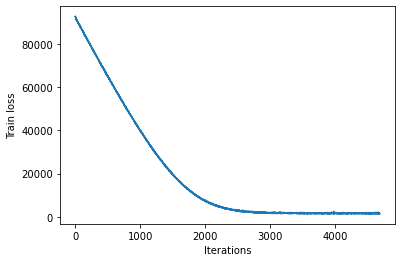

In [13]:
import matplotlib.pyplot as plt 

plt.plot(losses)
plt.xlabel('Iterations')
plt.ylabel('Train loss')
plt.show()